# Stochastic Volatility model

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

$$ \sigma \sim Exponential(50) $$

$$ \nu \sim Exponential(.1) $$

$$ s_i \sim Normal(s_{i-1}, \sigma^{-2}) $$

$$ log(r_i) \sim t(\nu, 0, exp(-2 s_i)) $$

Here, $r$ is the daily return series and $s$ is the latent log volatility process.

## Build Model

First we load some daily returns of the S&P 500.

In [36]:
n = 400
returns = pd.read_csv(pm.get_data("SP500.csv"), index_col='date')['change']
returns[:5]

date
2008-05-02    0.002764
2008-05-05   -0.004805
2008-05-06    0.008663
2008-05-07   -0.017811
2008-05-08   -0.002580
Name: change, dtype: float64

As you can see, the volatility seems to change over time quite a bit but cluster around certain time-periods. Around time-points 2500-3000 you can see the 2009 financial crash.

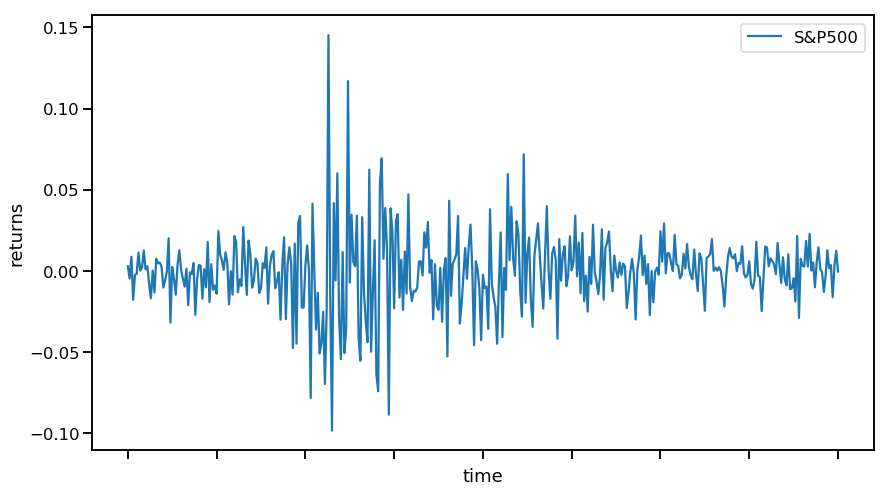

In [44]:
fig, ax = plt.subplots(figsize=(14, 8))
returns.plot(label='S&P500')
ax.set(xlabel='time', ylabel='returns')
ax.legend();

Specifying the model in `PyMC3` mirrors its statistical specification. 

In [38]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sigma=step_size, 
                           shape=len(returns))
    
    nu = pm.Exponential('nu', .1)
    
    r = pm.StudentT('r', nu=nu, 
                    lam=pm.math.exp(-2*s), 
                    observed=returns)

## Fit Model

For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. NUTS, however, gives the correct posterior.

In [39]:
with model:
    trace = pm.sample(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, s, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [02:32<00:00, 32.71draws/s]
/Users/twiecki/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8277688881384667, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


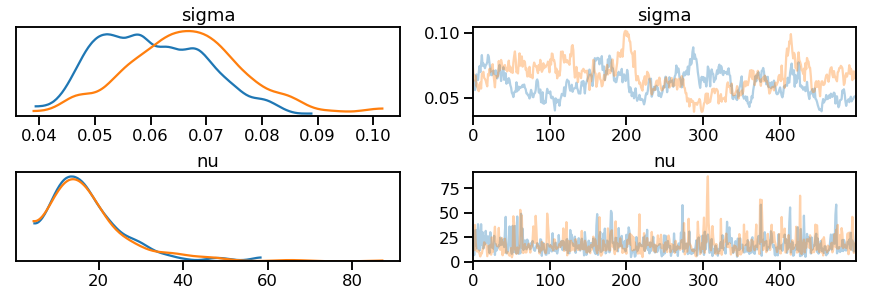

In [40]:
pm.traceplot(trace, var_names=['sigma', 'nu']);

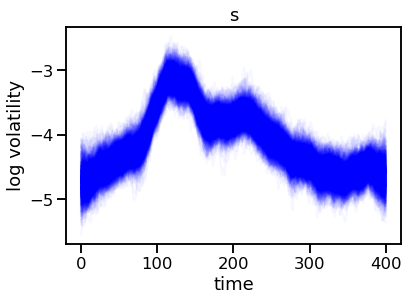

In [41]:
fig, ax = plt.subplots()

plt.plot(trace['s'].T, 'b', alpha=.03);
ax.set(title=str(s), xlabel='time', ylabel='log volatility');

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

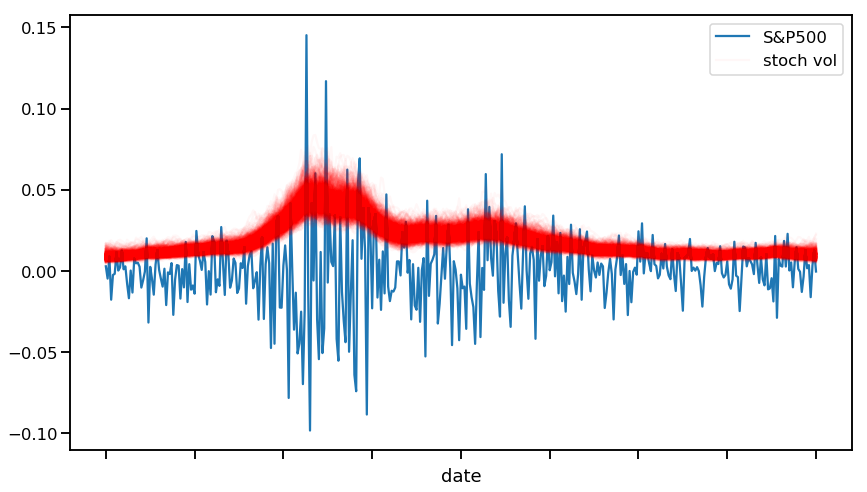

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))
returns.plot(ax=ax)
ax.plot(np.exp(trace[s].T), 'r', alpha=.03);
#ax.set(xlabel='time', ylabel='returns')
ax.legend(['S&P500', 'stoch vol']);

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 